<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1

Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,.,1,.,.,a,b,.,a
B,.,.,.,.,1,a,b,.,.,a,.
C,.,.,.,.,.,.,.,c,a,.,.
D,c,.,.,a,.,.,.,1,.,.,.
E,.,a,a,a,a,a,.,.,.,.,.
F,.,a,c,a,b,.,.,1,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 0 Puntos:74
Almacen: [.] Actual: [a]


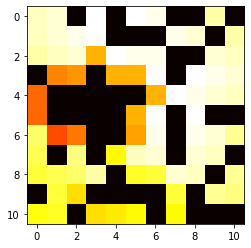

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,1,.,.,a,b,.,a
B,.,.,.,.,1,a,b,.,.,a,.
C,.,.,.,.,.,.,.,c,a,.,.
D,c,.,.,a,.,.,.,1,.,.,.
E,.,a,a,a,a,a,.,.,.,.,.
F,.,a,c,a,b,.,.,1,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 1 Puntos:75
Almacen: [.] Actual: [a]


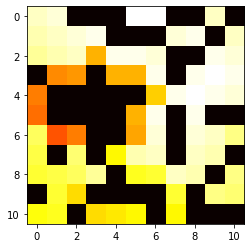

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,1,a,.,a,b,.,a
B,.,.,.,.,.,a,b,.,.,a,.
C,.,.,.,.,1,.,.,c,a,.,.
D,c,.,.,a,.,.,.,.,1,.,.
E,.,a,a,a,a,a,.,1,.,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 2 Puntos:76
Almacen: [.] Actual: [a]


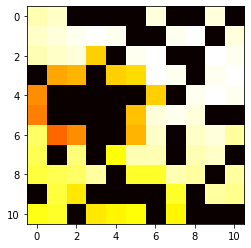

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,.,a,.,a,b,.,a
B,.,.,.,a,1,a,b,.,.,a,.
C,.,.,.,.,.,1,.,c,a,.,.
D,c,.,.,a,.,.,.,1,.,1,.
E,.,a,a,a,a,a,.,.,.,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 3 Puntos:77
Almacen: [.] Actual: [c]


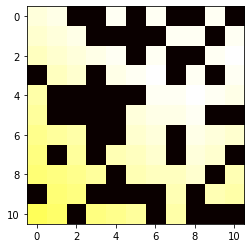

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,1,a,.,a,b,.,a
B,.,.,.,a,.,a,b,.,.,a,.
C,.,.,.,.,.,.,1,c,a,1,c
D,c,.,.,a,.,.,.,.,1,.,.
E,.,a,a,a,a,a,.,.,.,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 4 Puntos:102
Almacen: [.] Actual: [a]


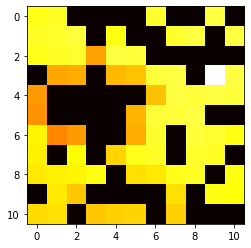

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,.,a,.,a,b,.,a
B,.,.,.,a,1,a,b,.,.,a,.
C,.,.,.,.,.,.,.,c,a,2,c
D,c,.,.,a,.,.,1,.,.,a,.
E,.,a,a,a,a,a,.,.,1,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 5 Puntos:123
Almacen: [.] Actual: [a]


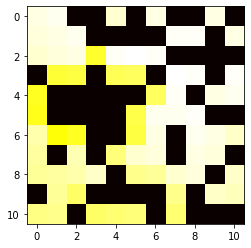

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,1,.,.,a,b,.,a
B,.,.,.,a,.,.,b,.,.,a,.
C,.,.,.,.,.,b,1,c,a,2,c
D,c,.,.,a,.,.,.,.,1,a,.
E,.,a,a,a,a,a,.,.,.,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 6 Puntos:126
Almacen: [.] Actual: [1]


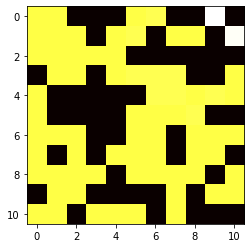

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,.,1,.,a,b,2,a
B,.,.,.,a,.,.,b,.,.,a,.
C,.,.,.,.,.,b,.,c,a,2,c
D,c,.,.,a,.,.,1,.,.,a,.
E,.,a,a,a,a,a,.,.,1,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 7 Puntos:121
Almacen: [.] Actual: [a]


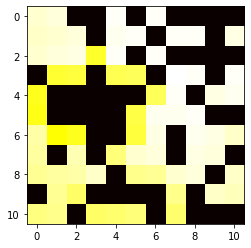

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,.,.,1,a,b,2,a
B,.,.,.,a,.,.,b,.,.,a,.
C,.,.,.,.,.,b,1,c,a,2,c
D,c,.,.,a,.,.,.,a,1,a,.
E,.,a,a,a,a,a,.,.,.,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 8 Puntos:122
Almacen: [.] Actual: [1]


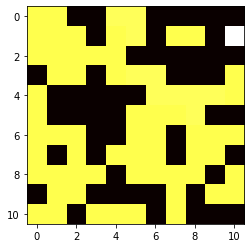

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,a,.,1,.,a,b,2,a
B,.,.,.,a,.,.,b,.,.,a,2
C,.,.,.,.,.,b,.,c,a,2,c
D,c,.,.,a,.,.,1,a,.,a,.
E,.,a,a,a,a,a,.,.,1,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 9 Puntos:117
Almacen: [.] Actual: [a]


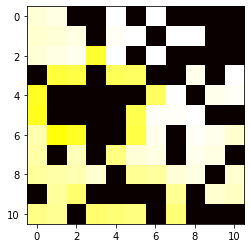

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,.,b,.,1,a,b,2,a
B,.,.,.,.,.,.,b,.,.,a,2
C,.,.,.,.,.,b,1,c,a,2,c
D,c,.,.,a,.,.,.,a,1,a,.
E,.,a,a,a,a,a,.,.,.,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 10 Puntos:120
Almacen: [.] Actual: [a]


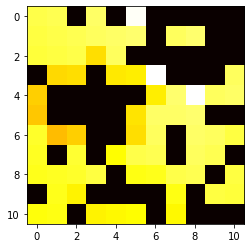

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,.,b,1,.,a,b,2,a
B,.,.,.,.,.,.,b,.,.,a,2
C,.,.,.,.,.,b,2,c,a,2,c
D,c,.,.,a,.,.,a,a,.,a,.
E,.,a,a,a,a,a,.,.,1,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 11 Puntos:141
Almacen: [.] Actual: [1]


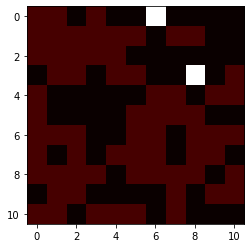

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,.,b,x,2,a,b,2,a
B,.,.,.,.,.,1,b,.,.,a,2
C,.,.,.,.,.,b,2,c,a,2,c
D,c,.,.,a,.,.,a,a,1,a,.
E,.,a,a,a,a,a,.,.,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 12 Puntos:36
Almacen: [.] Actual: [1]


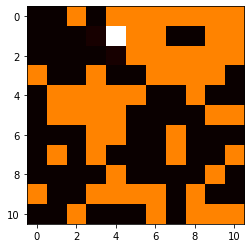

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,.,b,x,2,a,b,2,a
B,.,.,.,.,1,1,b,.,.,a,2
C,.,.,.,.,.,b,2,c,a,2,c
D,c,.,.,a,.,.,a,a,2,a,.
E,.,a,a,a,a,a,.,.,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 13 Puntos:31
Almacen: [.] Actual: [1]


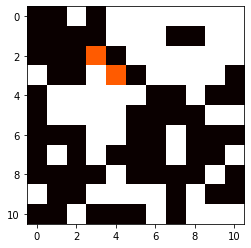

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,.,b,x,2,a,b,2,a
B,.,.,.,.,.,1,b,.,.,a,2
C,.,.,.,1,1,b,2,c,a,2,c
D,c,.,.,a,.,.,a,a,2,a,.
E,.,a,a,a,a,a,.,.,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 14 Puntos:6
Almacen: [.] Actual: [a]


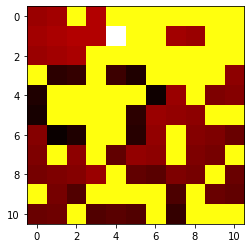

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,.,b,x,2,a,b,2,a
B,.,.,.,1,a,2,b,.,.,a,2
C,.,.,.,.,.,b,2,c,a,2,c
D,c,.,.,a,1,.,a,a,2,a,.
E,.,a,a,a,a,a,.,.,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 15 Puntos:27
Almacen: [.] Actual: [a]


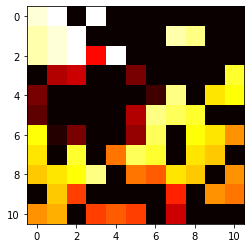

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,1,b,x,2,a,b,2,a
B,.,.,.,.,a,2,b,.,.,a,2
C,.,.,.,.,1,b,2,c,a,2,c
D,c,.,.,a,.,.,a,a,2,a,.
E,.,a,a,a,a,a,.,.,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 16 Puntos:28
Almacen: [.] Actual: [b]


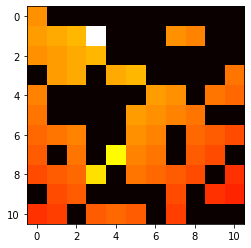

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,.,b,a,2,b,.,.,a,2
C,.,.,.,.,.,b,2,c,a,2,c
D,c,.,.,a,1,.,a,a,2,a,.
E,.,a,a,a,a,a,.,.,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 17 Puntos:53
Almacen: [.] Actual: [1]


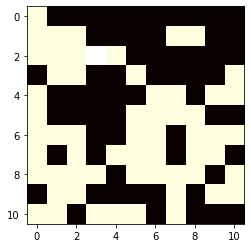

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,.,b,a,2,b,.,.,a,2
C,.,.,.,1,1,b,2,c,a,2,c
D,c,.,.,a,.,.,a,a,2,a,.
E,.,a,a,a,a,a,.,.,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 18 Puntos:28
Almacen: [.] Actual: [a]


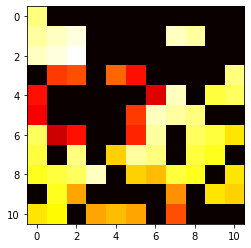

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,.,b,a,2,b,.,.,a,2
C,.,.,a,.,1,b,2,c,a,2,c
D,c,.,.,a,1,.,a,a,2,a,.
E,.,a,a,a,a,a,.,.,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 19 Puntos:29
Almacen: [.] Actual: [a]


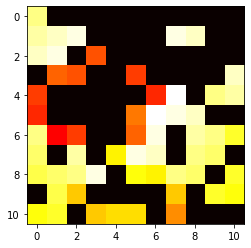

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,.,b,a,2,b,.,.,a,2
C,.,.,a,.,.,b,2,c,a,2,c
D,c,.,.,a,1,1,.,.,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 20 Puntos:32
Almacen: [.] Actual: [a]


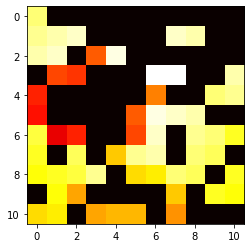

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,.,b,a,2,b,.,.,a,2
C,.,.,a,.,1,b,2,c,a,2,c
D,c,.,.,a,.,1,a,.,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 21 Puntos:33
Almacen: [.] Actual: [a]


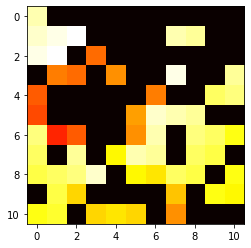

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,a,b,a,2,b,.,.,a,2
C,.,.,a,1,.,b,2,c,a,2,c
D,c,.,.,a,1,.,a,.,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 22 Puntos:34
Almacen: [.] Actual: [b]


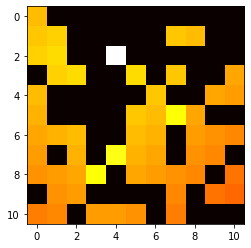

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,a,b,a,2,b,.,.,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,.,1,a,.,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 23 Puntos:59
Almacen: [.] Actual: [a]


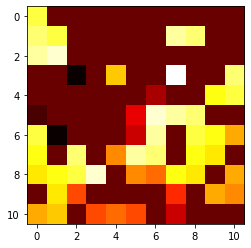

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,a,b,a,2,b,.,.,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,1,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,b,.,.,.,a,.,.,a
I,.,.,.,.,b,.,.,.,.,a,.
J,a,.,.,a,a,a,a,.,c,.,.



Turno: 24 Puntos:10
Almacen: [.] Actual: [a]


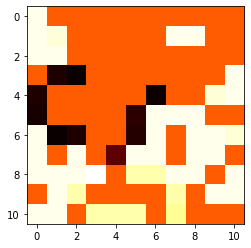

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,b,2,b,x,2,a,b,2,a
B,.,.,a,b,a,2,b,.,.,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 25 Puntos:40
Almacen: [.] Actual: [a]


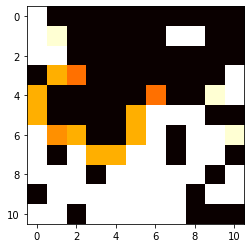

,0,1,2,3,4,5,6,7,8,9,10
A,a,a,b,2,b,x,2,a,b,2,a
B,.,.,a,b,a,2,b,.,.,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 26 Puntos:41
Almacen: [.] Actual: [a]


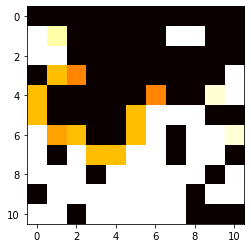

,0,1,2,3,4,5,6,7,8,9,10
A,.,.,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,.,.,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 27 Puntos:44
Almacen: [.] Actual: [1]


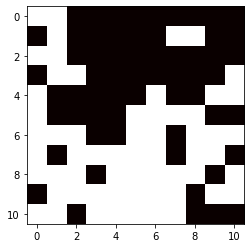

,0,1,2,3,4,5,6,7,8,9,10
A,1,.,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,.,.,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 28 Puntos:19
Almacen: [.] Actual: [a]


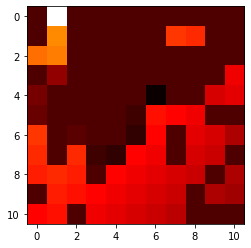

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,.,.,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 29 Puntos:40
Almacen: [.] Actual: [a]


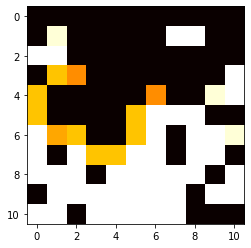

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,a,.,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 30 Puntos:41
Almacen: [.] Actual: [1]


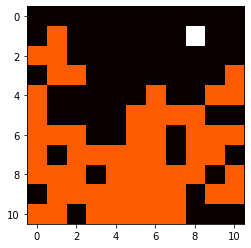

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,a,2,a,2
C,.,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 31 Puntos:36
Almacen: [.] Actual: [a]


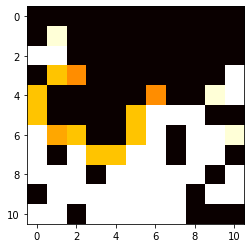

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,a,2,a,2
C,a,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,.
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 32 Puntos:37
Almacen: [.] Actual: [a]


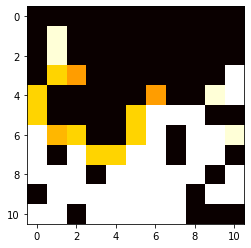

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,a,2,a,2
C,a,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 33 Puntos:38
Almacen: [.] Actual: [a]


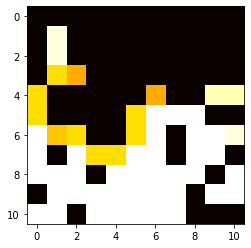

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,a,2,a,2
C,a,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 34 Puntos:39
Almacen: [.] Actual: [a]


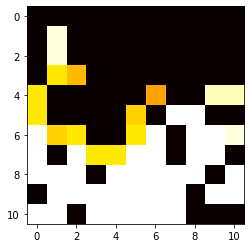

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,a,2,a,2
C,a,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,.,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 35 Puntos:40
Almacen: [.] Actual: [a]


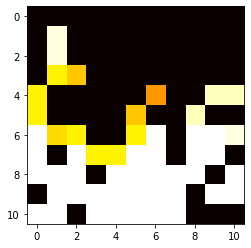

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,.,a,b,a,2,b,a,2,a,2
C,a,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 36 Puntos:41
Almacen: [.] Actual: [b]


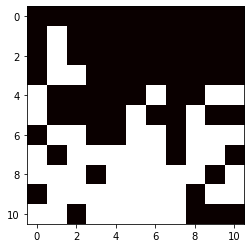

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,b,b,a,b,a,2,b,a,2,a,2
C,a,.,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 37 Puntos:46
Almacen: [.] Actual: [a]


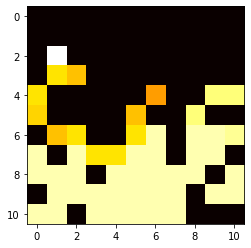

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,.,.,.,b,a,2,b,a,2,a,2
C,.,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 38 Puntos:58
Almacen: [.] Actual: [a]


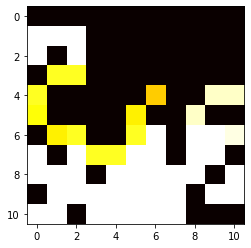

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,b,2,b,x,2,a,b,2,a
B,a,.,.,b,a,2,b,a,2,a,2
C,.,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 39 Puntos:59
Almacen: [.] Actual: [b]


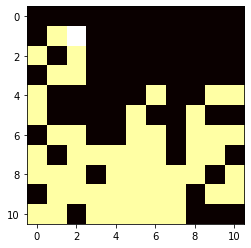

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,.,2,b,x,2,a,b,2,a
B,a,.,c,.,a,2,b,a,2,a,2
C,.,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 40 Puntos:74
Almacen: [.] Actual: [w]


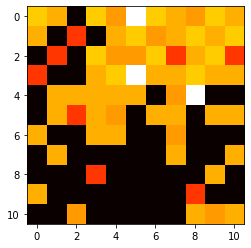

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,.,2,b,.,2,a,b,2,a
B,a,.,c,.,a,2,b,a,2,a,2
C,.,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 41 Puntos:124
Almacen: [.] Actual: [a]


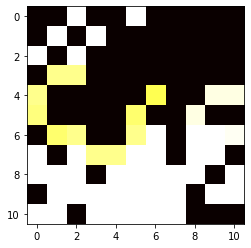

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,.,2,a,b,2,a
B,a,.,c,.,a,2,b,a,2,a,2
C,.,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 42 Puntos:125
Almacen: [.] Actual: [1]


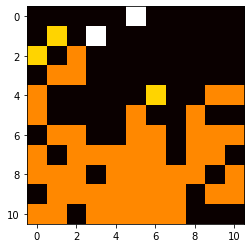

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,.,.,a,b,2,a
B,a,.,c,.,a,3,b,a,2,a,2
C,.,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 43 Puntos:185
Almacen: [.] Actual: [a]


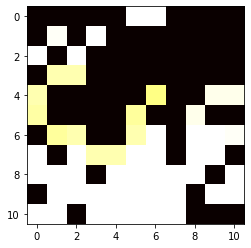

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,.,a,3,b,a,2,a,2
C,.,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 44 Puntos:186
Almacen: [.] Actual: [a]


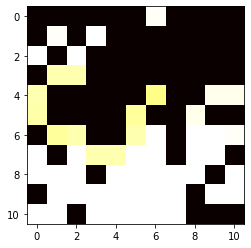

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,.,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 45 Puntos:187
Almacen: [.] Actual: [a]


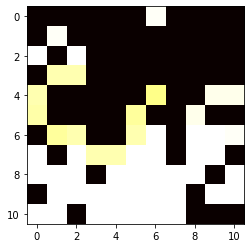

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,.,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 46 Puntos:188
Almacen: [.] Actual: [a]


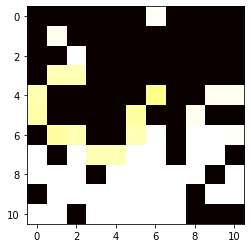

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,.,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 47 Puntos:189
Almacen: [.] Actual: [a]


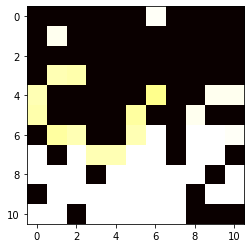

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,b,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 48 Puntos:192
Almacen: [.] Actual: [a]


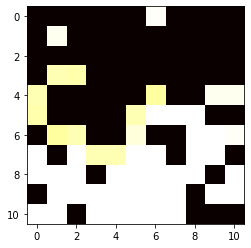

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,b,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 49 Puntos:193
Almacen: [.] Actual: [a]


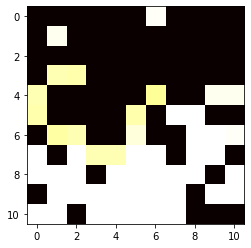

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,b,b,.,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 50 Puntos:194
Almacen: [.] Actual: [a]


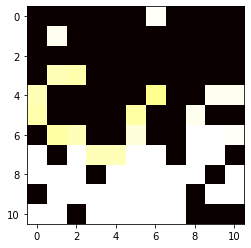

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,b,b,a,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 51 Puntos:195
Almacen: [.] Actual: [b]


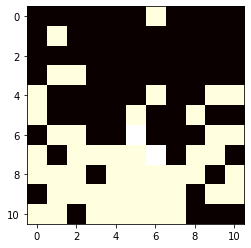

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,c,.,.,a,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 52 Puntos:210
Almacen: [.] Actual: [a]


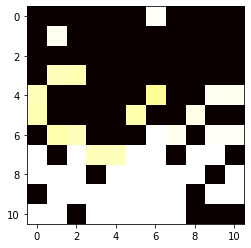

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,.,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 53 Puntos:213
Almacen: [.] Actual: [1]


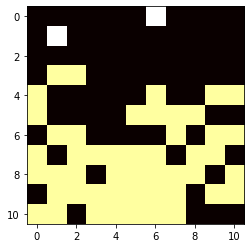

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 54 Puntos:208
Almacen: [.] Actual: [a]


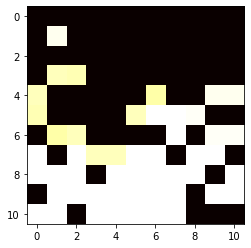

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,.,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 55 Puntos:209
Almacen: [.] Actual: [1]


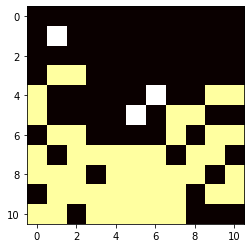

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 56 Puntos:204
Almacen: [.] Actual: [a]


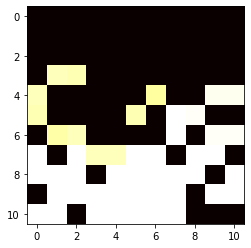

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,.,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 57 Puntos:205
Almacen: [.] Actual: [b]


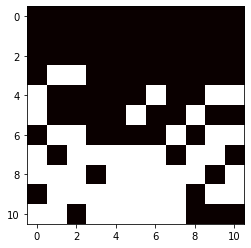

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,.,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 58 Puntos:210
Almacen: [.] Actual: [a]


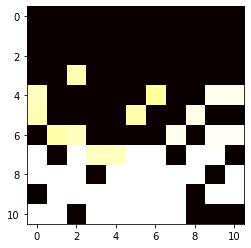

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,.,.,.,a,a,c,b,.,a,.,.
H,b,.,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 59 Puntos:213
Almacen: [.] Actual: [a]


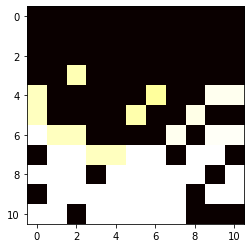

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,b,.,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 60 Puntos:214
Almacen: [.] Actual: [a]


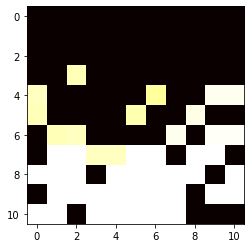

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,b,a,.,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 61 Puntos:215
Almacen: [.] Actual: [a]


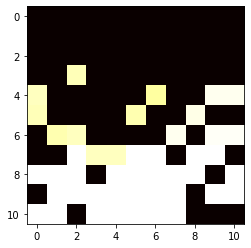

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,b,a,a,.,.,.,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 62 Puntos:216
Almacen: [.] Actual: [a]


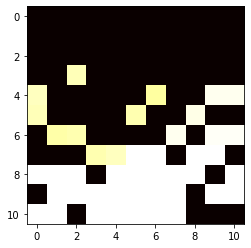

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,b,a,a,.,.,a,.,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 63 Puntos:217
Almacen: [.] Actual: [a]


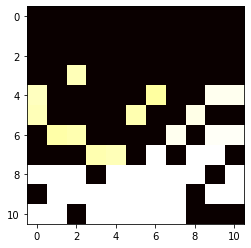

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,c,b,.,a,.,.
H,b,a,a,.,.,.,b,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 64 Puntos:220
Almacen: [.] Actual: [a]


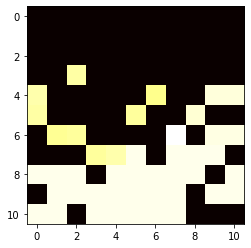

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,c,.,c,.,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 65 Puntos:232
Almacen: [.] Actual: [c]


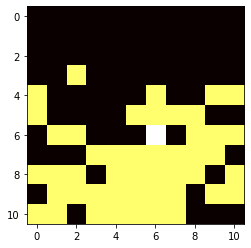

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,.,.,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 66 Puntos:307
Almacen: [.] Actual: [a]


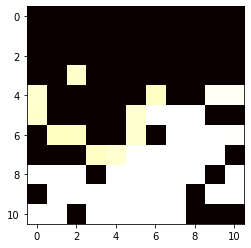

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,.,.,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 67 Puntos:308
Almacen: [.] Actual: [a]


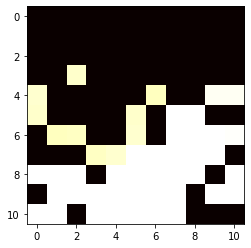

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,.,.,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 68 Puntos:309
Almacen: [.] Actual: [a]


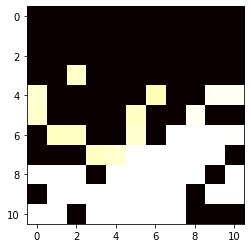

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,.,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 69 Puntos:312
Almacen: [.] Actual: [1]


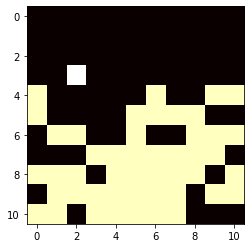

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 70 Puntos:307
Almacen: [.] Actual: [a]


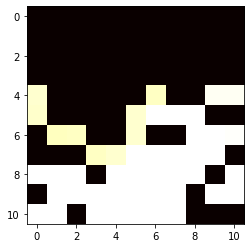

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 71 Puntos:308
Almacen: [.] Actual: [a]


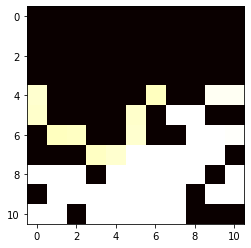

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 72 Puntos:309
Almacen: [.] Actual: [a]


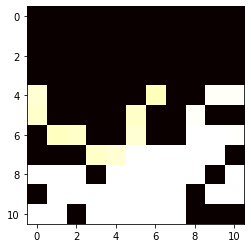

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,.,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 73 Puntos:310
Almacen: [.] Actual: [a]


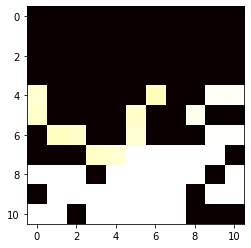

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,a,.,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 74 Puntos:311
Almacen: [.] Actual: [a]


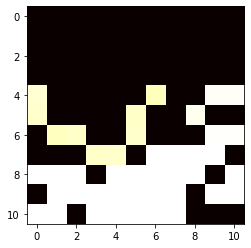

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,a,a,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 75 Puntos:312
Almacen: [.] Actual: [a]


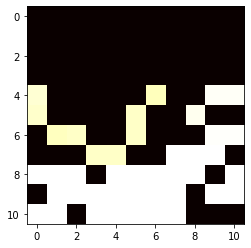

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,.,.,b,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 76 Puntos:315
Almacen: [.] Actual: [a]


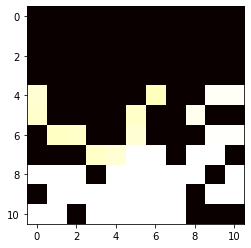

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,a,.,b,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 77 Puntos:316
Almacen: [.] Actual: [b]


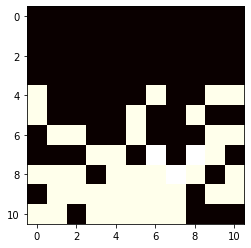

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,.,a,.,.
H,b,a,a,.,.,a,c,.,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 78 Puntos:331
Almacen: [.] Actual: [a]


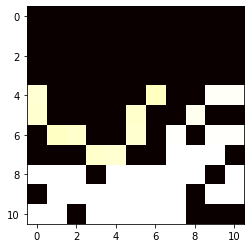

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,.,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,.,a,.,.
H,b,a,a,.,.,a,c,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 79 Puntos:332
Almacen: [.] Actual: [1]


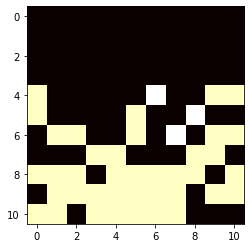

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,x,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,.,a,.,.
H,b,a,a,.,.,a,c,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 80 Puntos:327
Almacen: [.] Actual: [w]


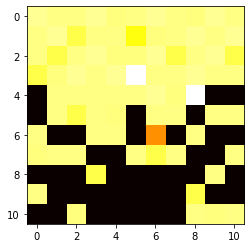

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,.,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,.,a,.,.
H,b,a,a,.,.,a,c,a,.,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 81 Puntos:377
Almacen: [.] Actual: [a]


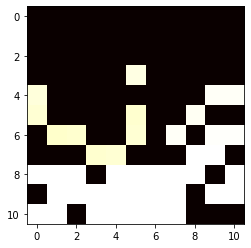

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,.,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,.,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 82 Puntos:380
Almacen: [.] Actual: [a]


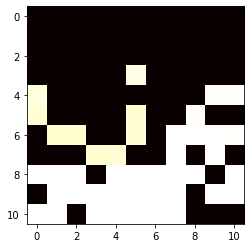

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,b,2,c,a,2,c
D,c,b,2,a,2,.,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 83 Puntos:383
Almacen: [.] Actual: [b]


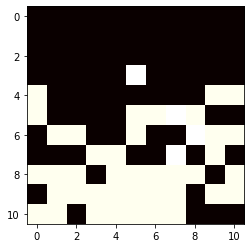

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,.,.,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 84 Puntos:398
Almacen: [.] Actual: [a]


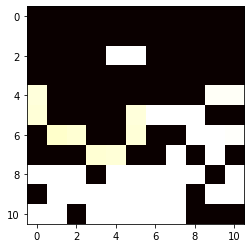

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,.,.,3,b,a,2,a,2
C,a,c,a,2,b,.,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 85 Puntos:401
Almacen: [.] Actual: [a]


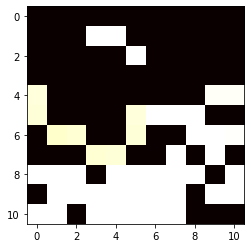

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,.,3,b,a,2,a,2
C,a,c,a,2,b,.,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 86 Puntos:402
Almacen: [.] Actual: [a]


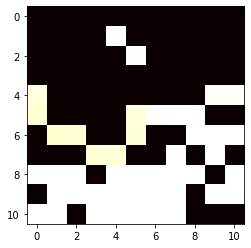

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,.,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 87 Puntos:403
Almacen: [.] Actual: [a]


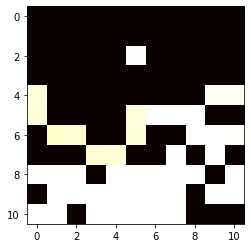

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,.,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 88 Puntos:404
Almacen: [.] Actual: [a]


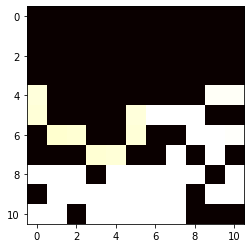

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 89 Puntos:405
Almacen: [.] Actual: [1]


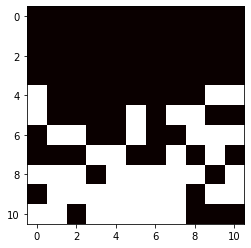

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,1,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 90 Puntos:380
Almacen: [.] Actual: [a]


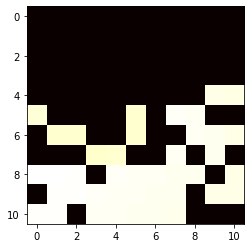

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,1,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,a,.,.,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 91 Puntos:381
Almacen: [.] Actual: [a]


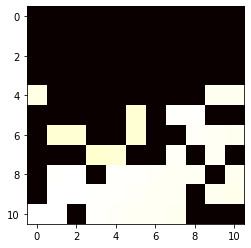

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,1,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,.,.,.,.,a,c,.,b,.,a
I,a,.,b,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 92 Puntos:384
Almacen: [.] Actual: [a]


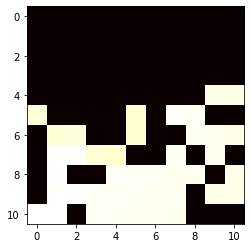

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,1,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,.,.,.,a,c,.,b,.,a
I,a,.,b,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 93 Puntos:385
Almacen: [.] Actual: [a]


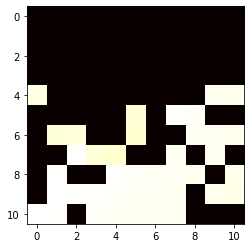

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,1,a,a,a,a,a,2,b,x,.,.
F,.,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,a,.,b,c,.,.,.,.,.,a,.
J,a,.,.,.,.,.,.,.,c,.,.



Turno: 94 Puntos:386
Almacen: [.] Actual: [a]


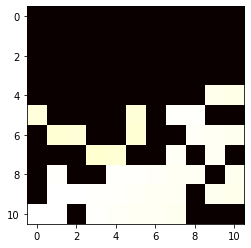

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,.,a,a,a,a,a,2,b,x,.,.
F,1,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,b,c,.,.,.,.,.,a,.
J,.,b,.,.,.,.,.,.,c,.,.



Turno: 95 Puntos:389
Almacen: [.] Actual: [1]


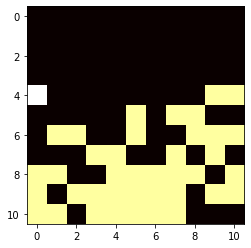

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,.,.
F,2,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,.,b,c,.,.,.,.,.,a,.
J,.,b,.,.,.,.,.,.,c,.,.



Turno: 96 Puntos:404
Almacen: [.] Actual: [a]


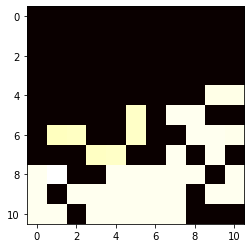

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,.,.
F,2,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,.,.,.,.,a,c,.,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 97 Puntos:417
Almacen: [.] Actual: [1]


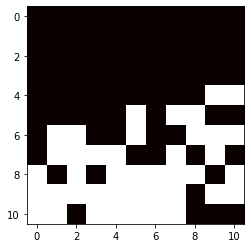

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,1,.
F,2,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,.,.,.,.,a,c,.,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 98 Puntos:392
Almacen: [.] Actual: [b]


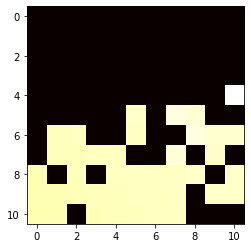

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,.,a,.,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,.,.,.,.,a,c,.,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 99 Puntos:417
Almacen: [.] Actual: [a]


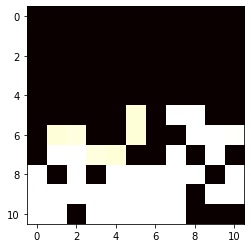

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,b,.,.,.
H,b,.,.,.,.,a,c,.,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 100 Puntos:418
Almacen: [.] Actual: [a]


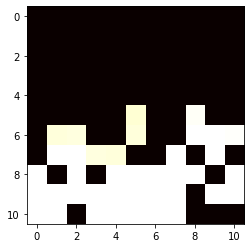

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,.,a,a,.,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,.,.,.,.,a,c,.,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 101 Puntos:419
Almacen: [.] Actual: [1]


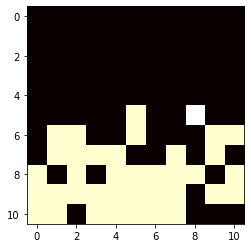

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,.,a,a,2,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,.,.,.,.,a,c,.,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 102 Puntos:414
Almacen: [.] Actual: [a]


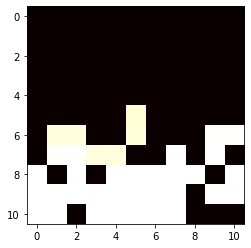

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,.,a,a,2,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,.,.,.,a,c,.,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 103 Puntos:415
Almacen: [.] Actual: [a]


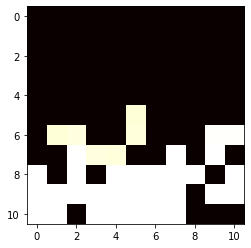

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,.,a,a,2,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,a,c,.,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 104 Puntos:416
Almacen: [.] Actual: [a]


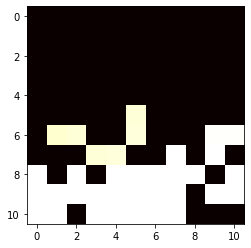

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,.,a,a,2,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,a,c,a,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 105 Puntos:417
Almacen: [.] Actual: [1]


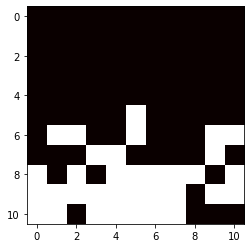

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,1,a,a,2,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,a,c,a,b,.,a
I,.,c,.,c,.,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 106 Puntos:392
Almacen: [.] Actual: [a]


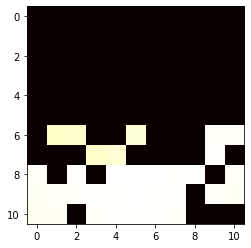

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,.,a,a,2,a,a
G,a,.,.,a,a,1,d,b,a,.,.
H,b,a,a,.,.,a,c,a,b,.,a
I,.,c,.,c,.,a,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 107 Puntos:393
Almacen: [.] Actual: [a]


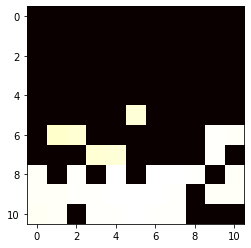

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,1,a,a,2,a,a
G,a,.,.,a,a,.,d,b,a,.,.
H,b,a,a,.,.,.,c,a,b,.,a
I,.,c,.,c,b,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 108 Puntos:396
Almacen: [.] Actual: [1]


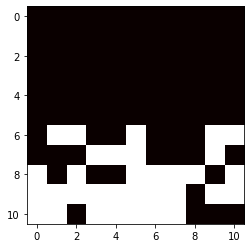

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,1,a,a,2,a,a
G,a,.,.,a,a,1,d,b,a,.,.
H,b,a,a,.,.,.,c,a,b,.,a
I,.,c,.,c,b,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 109 Puntos:371
Almacen: [.] Actual: [a]


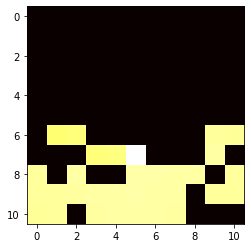

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,2,a,a,2,a,a
G,a,.,.,a,a,2,d,b,a,.,.
H,b,a,a,.,.,a,c,a,b,.,a
I,.,c,.,c,b,.,.,.,.,a,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 110 Puntos:412
Almacen: [.] Actual: [a]


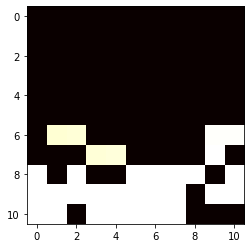

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,2,a,a,2,a,a
G,a,.,.,a,a,2,d,b,a,.,.
H,b,a,a,.,.,a,c,a,b,b,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 111 Puntos:415
Almacen: [.] Actual: [1]


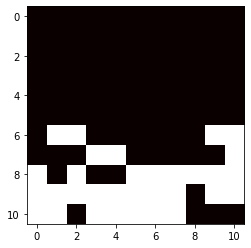

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,2,a,a,2,a,a
G,a,1,.,a,a,2,d,b,a,.,.
H,b,a,a,.,.,a,c,a,b,b,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 112 Puntos:390
Almacen: [.] Actual: [a]


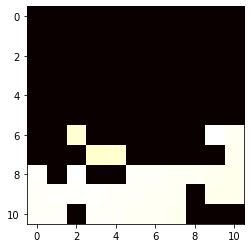

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,x,2,b
F,2,a,c,a,b,2,a,a,2,.,.
G,a,.,1,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 113 Puntos:402
Almacen: [.] Actual: [w]


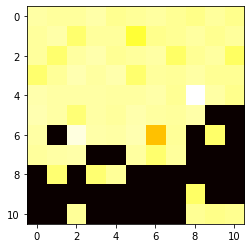

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,2,a,a
E,2,a,a,a,a,a,2,b,.,2,b
F,2,a,c,a,b,2,a,a,2,.,.
G,a,.,1,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 114 Puntos:452
Almacen: [.] Actual: [1]


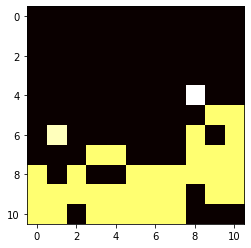

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,.,.,b
F,2,a,c,a,b,2,a,a,.,.,.
G,a,1,.,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 115 Puntos:517
Almacen: [.] Actual: [b]


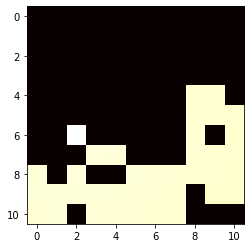

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,.,.,b
F,2,a,c,a,b,2,a,a,.,.,.
G,a,2,b,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 116 Puntos:542
Almacen: [.] Actual: [a]


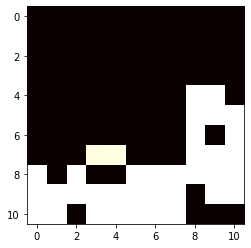

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,.,b
F,2,a,c,a,b,2,a,a,.,.,.
G,a,2,b,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 117 Puntos:543
Almacen: [.] Actual: [a]


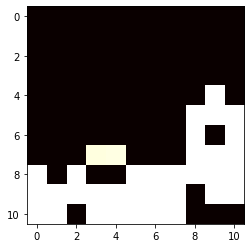

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,.,b
F,2,a,c,a,b,2,a,a,.,a,.
G,a,2,b,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 118 Puntos:544
Almacen: [.] Actual: [a]


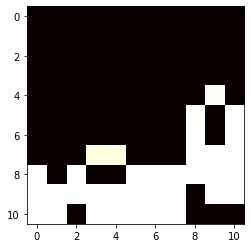

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,.,b
F,2,a,c,a,b,2,a,a,.,a,a
G,a,2,b,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 119 Puntos:545
Almacen: [.] Actual: [b]


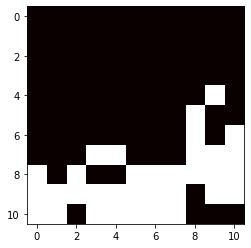

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,.,a,a
G,a,2,b,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 120 Puntos:550
Almacen: [.] Actual: [b]


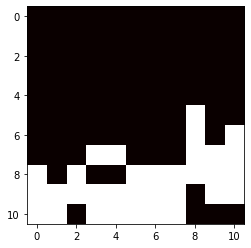

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,.,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 121 Puntos:555
Almacen: [.] Actual: [a]


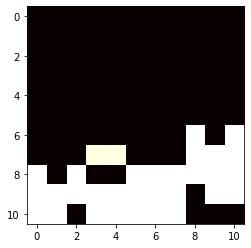

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,.
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 122 Puntos:556
Almacen: [.] Actual: [1]


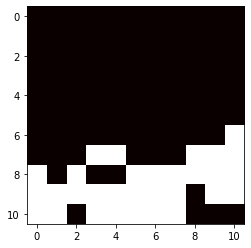

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,1
H,b,a,a,.,.,a,c,a,.,.,.
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 123 Puntos:531
Almacen: [.] Actual: [a]


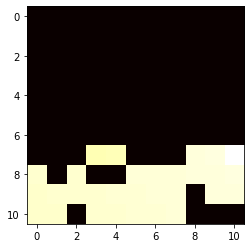

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,a,a,.,.,a,c,a,.,.,a
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 124 Puntos:552
Almacen: [.] Actual: [a]


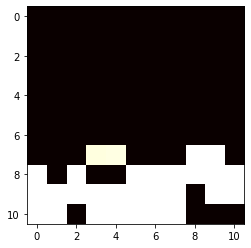

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,.,c,2
H,b,a,a,.,.,a,c,.,b,.,a
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 125 Puntos:555
Almacen: [.] Actual: [a]


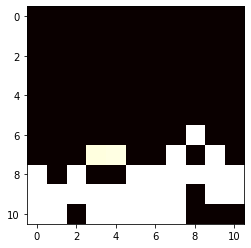

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,a,a,.,.,a,c,.,b,.,a
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 126 Puntos:556
Almacen: [.] Actual: [a]


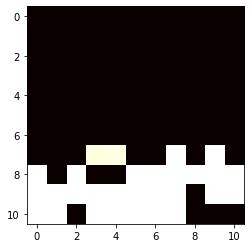

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,a,a,.,.,a,c,a,b,.,a
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 127 Puntos:557
Almacen: [.] Actual: [a]


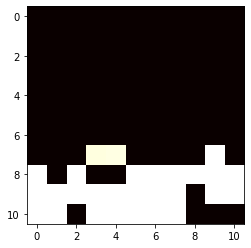

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,a,a,.,.,a,c,a,b,a,a
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 128 Puntos:558
Almacen: [.] Actual: [1]


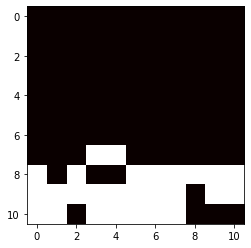

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,a,a,1,.,a,c,a,b,a,a
I,.,c,.,c,b,.,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 129 Puntos:533
Almacen: [.] Actual: [a]


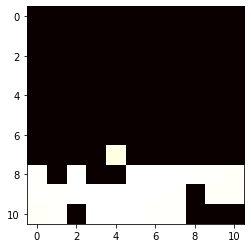

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,a,a,.,1,a,c,a,b,a,a
I,.,c,.,c,b,a,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 130 Puntos:534
Almacen: [.] Actual: [a]


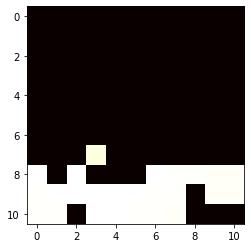

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,.,.,1,.,a,c,a,b,a,a
I,.,c,b,c,b,a,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 131 Puntos:537
Almacen: [.] Actual: [1]


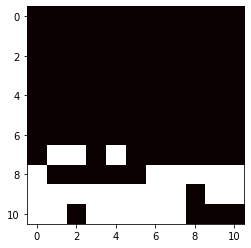

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,1,.,.,1,a,c,a,b,a,a
I,.,c,b,c,b,a,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 132 Puntos:512
Almacen: [.] Actual: [a]


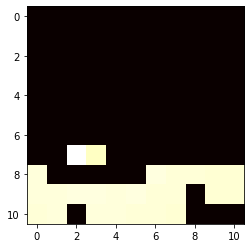

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,1,.,a,c,a,b,a,a
I,.,c,b,c,b,a,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 133 Puntos:533
Almacen: [.] Actual: [w]


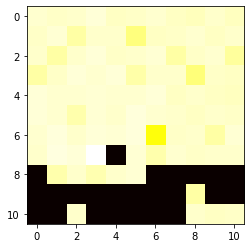

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,.,a,c,a,b,a,a
I,.,c,b,c,b,a,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 134 Puntos:558
Almacen: [.] Actual: [a]


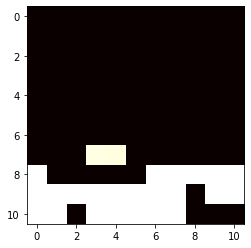

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,.,a,c,a,b,a,a
I,a,c,b,c,b,a,.,.,.,.,.
J,.,.,.,.,.,.,.,.,c,.,.



Turno: 135 Puntos:559
Almacen: [.] Actual: [b]


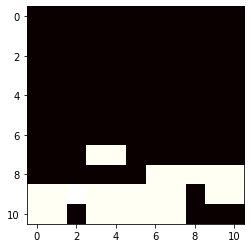

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,.,a,c,a,b,a,a
I,a,c,.,c,b,a,.,.,.,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 136 Puntos:574
Almacen: [.] Actual: [a]


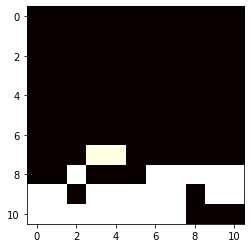

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,.,a,c,a,b,a,a
I,a,c,a,c,b,a,.,.,.,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 137 Puntos:575
Almacen: [.] Actual: [b]


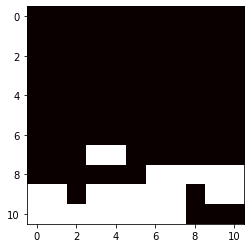

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,.,a,c,a,b,a,a
I,a,c,a,c,b,a,.,.,.,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 138 Puntos:580
Almacen: [.] Actual: [w]


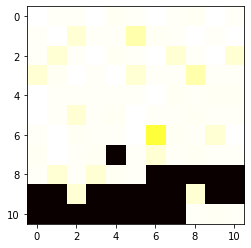

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,.,a,c,a,b,a,a
I,a,c,a,c,b,a,.,.,.,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 139 Puntos:585
Almacen: [.] Actual: [a]


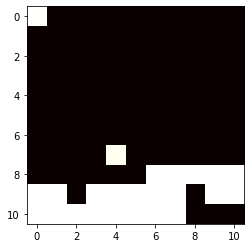

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,.,.,c,a,b,a,a
I,a,c,a,c,b,.,b,.,.,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 140 Puntos:588
Almacen: [.] Actual: [a]


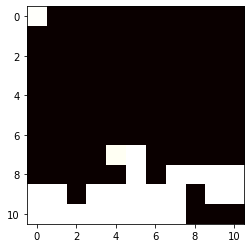

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,.,a,c,a,b,a,a
I,a,c,a,c,b,.,b,.,.,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 141 Puntos:589
Almacen: [.] Actual: [a]


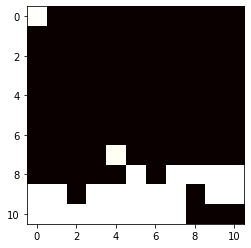

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,.,a,c,a,b,a,a
I,a,c,a,c,b,a,b,.,.,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 142 Puntos:590
Almacen: [.] Actual: [a]


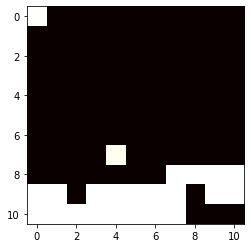

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,.,a,c,a,b,a,a
I,a,c,a,c,b,a,b,a,.,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 143 Puntos:591
Almacen: [.] Actual: [a]


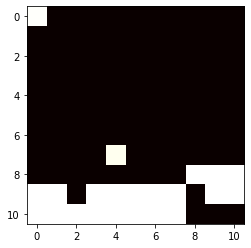

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,.,a,c,.,b,a,a
I,a,c,a,c,b,a,b,.,b,.,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 144 Puntos:594
Almacen: [.] Actual: [a]


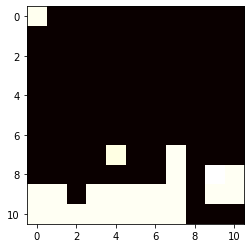

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,.,a,c,.,.,.,.
I,a,c,a,c,b,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 145 Puntos:607
Almacen: [.] Actual: [b]


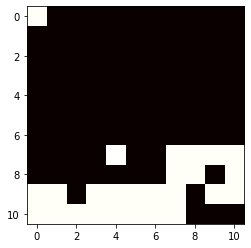

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,.,.,.,.
I,a,c,a,c,.,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 146 Puntos:622
Almacen: [.] Actual: [1]


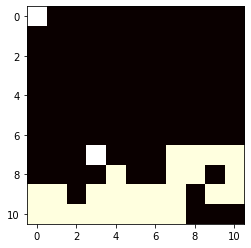

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,.,.,.,.
I,a,c,a,c,.,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 147 Puntos:617
Almacen: [.] Actual: [a]


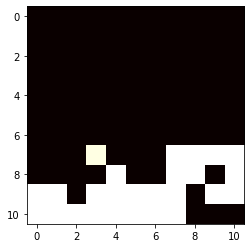

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,a,.,.,.
I,a,c,a,c,.,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 148 Puntos:618
Almacen: [.] Actual: [a]


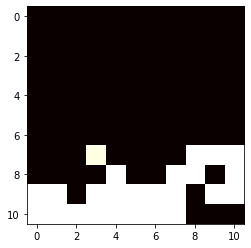

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,.,c,2
H,b,2,a,.,c,a,c,.,b,.,.
I,a,c,a,c,.,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 149 Puntos:621
Almacen: [.] Actual: [a]


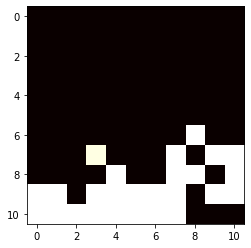

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,.,b,.,.
I,a,c,a,c,.,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 150 Puntos:622
Almacen: [.] Actual: [a]


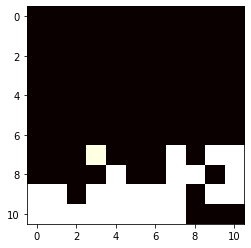

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,a,b,.,.
I,a,c,a,c,.,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 151 Puntos:623
Almacen: [.] Actual: [a]


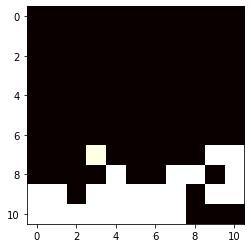

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,a,b,a,.
I,a,c,a,c,.,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 152 Puntos:624
Almacen: [.] Actual: [a]


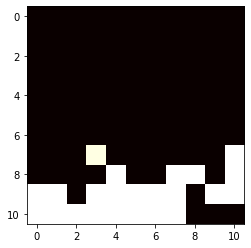

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,a,b,a,a
I,a,c,a,c,.,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 153 Puntos:625
Almacen: [.] Actual: [a]


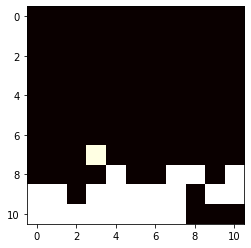

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,.,c,a,b,a,a
I,a,c,a,c,b,.,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 154 Puntos:628
Almacen: [.] Actual: [a]


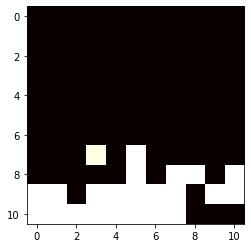

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,a,b,a,a
I,a,c,a,c,b,.,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 155 Puntos:629
Almacen: [.] Actual: [a]


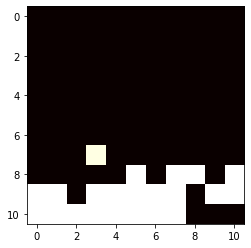

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,a,b,a,a
I,a,c,a,c,b,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 156 Puntos:630
Almacen: [.] Actual: [a]


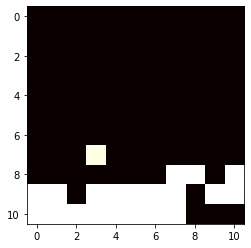

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,.,c,a,c,a,b,a,a
I,a,c,a,c,b,a,b,a,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 157 Puntos:631
Almacen: [.] Actual: [b]


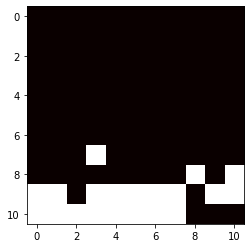

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,a,b,a,a
I,a,c,a,c,b,a,b,a,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 158 Puntos:636
Almacen: [.] Actual: [a]


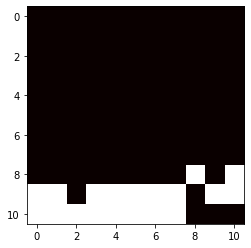

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,.,b,a,a
I,a,c,a,c,b,a,b,.,b,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 159 Puntos:639
Almacen: [.] Actual: [b]


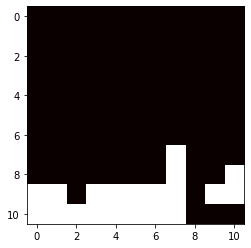

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,.,a,c,2
H,b,2,a,b,c,a,c,c,.,a,a
I,a,c,a,c,b,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 160 Puntos:649
Almacen: [.] Actual: [b]


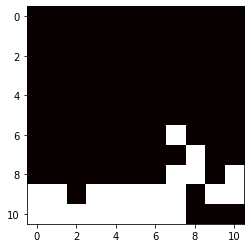

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,.,a,a
I,a,c,a,c,b,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 161 Puntos:654
Almacen: [.] Actual: [1]


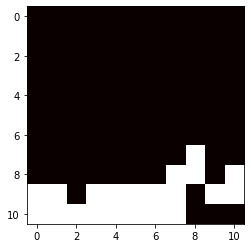

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,1,a,a
I,a,c,a,c,b,a,b,.,.,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 162 Puntos:629
Almacen: [.] Actual: [a]


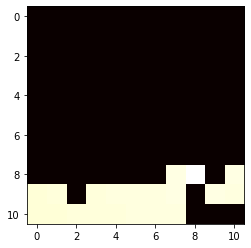

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,a,a
I,a,c,a,c,b,a,b,.,a,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 163 Puntos:650
Almacen: [.] Actual: [1]


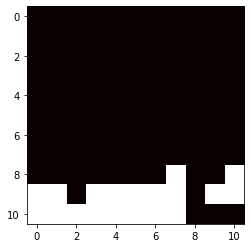

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,a,a
I,a,c,a,c,b,a,b,1,a,c,.
J,.,.,c,.,.,.,.,.,c,.,.



Turno: 164 Puntos:625
Almacen: [.] Actual: [a]


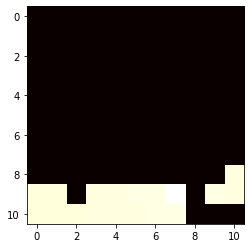

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,a,a
I,a,c,a,c,b,a,b,2,a,c,.
J,.,.,c,.,.,.,.,a,c,.,.



Turno: 165 Puntos:646
Almacen: [.] Actual: [a]


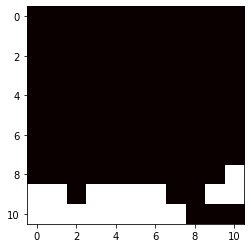

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,.,.
I,a,c,a,c,b,a,b,2,a,c,b
J,.,.,c,.,.,.,.,a,c,.,.



Turno: 166 Puntos:649
Almacen: [.] Actual: [b]


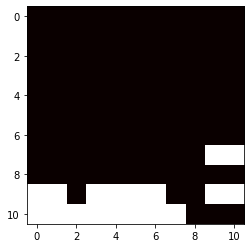

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,.
I,a,c,a,c,b,a,b,2,a,c,b
J,.,.,c,.,.,.,.,a,c,.,.



Turno: 167 Puntos:654
Almacen: [.] Actual: [1]


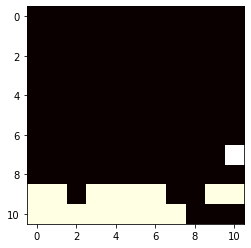

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,c,b
J,.,.,c,.,.,.,.,a,c,.,.



Turno: 168 Puntos:649
Almacen: [.] Actual: [a]


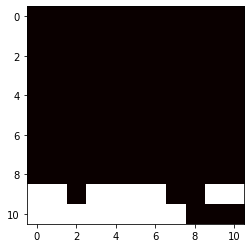

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,c,b
J,a,.,c,.,.,.,.,a,c,.,.



Turno: 169 Puntos:650
Almacen: [.] Actual: [b]


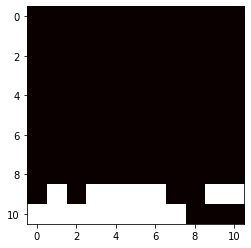

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,c,b
J,a,b,c,.,.,.,.,a,c,.,.



Turno: 170 Puntos:655
Almacen: [.] Actual: [b]


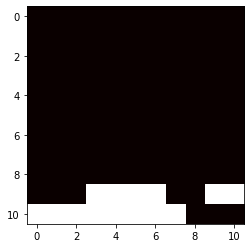

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,c,b
J,a,b,c,b,.,.,.,a,c,.,.



Turno: 171 Puntos:660
Almacen: [.] Actual: [1]


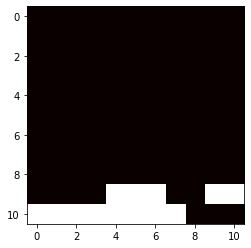

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,c,b
J,a,b,c,b,1,.,.,a,c,.,.



Turno: 172 Puntos:635
Almacen: [.] Actual: [c]


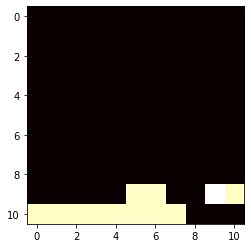

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,.,b
J,a,b,c,b,.,1,.,a,.,d,.



Turno: 173 Puntos:710
Almacen: [.] Actual: [1]


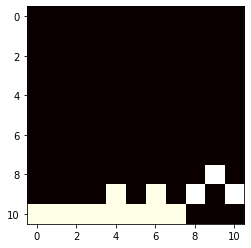

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,.,b
J,a,b,c,b,.,.,1,a,2,d,.



Turno: 174 Puntos:705
Almacen: [.] Actual: [a]


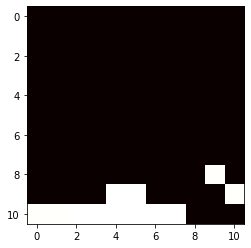

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,.,b
J,a,b,c,b,.,.,.,a,2,d,.



Turno: 175 Puntos:706
Almacen: [.] Actual: [1]


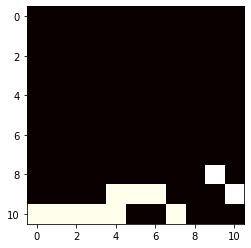

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,2,b
J,a,b,c,b,.,.,1,a,2,d,.



Turno: 176 Puntos:701
Almacen: [.] Actual: [a]


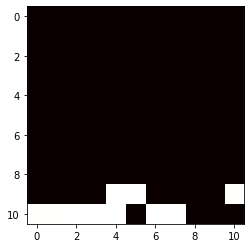

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,2,a,2,b
J,a,b,c,b,.,.,.,1,2,d,.



Turno: 177 Puntos:704
Almacen: [.] Actual: [a]


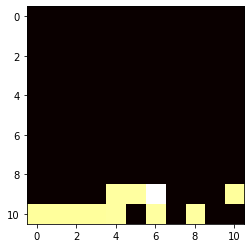

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,.,.,a,.,.,d,.



Turno: 178 Puntos:790
Almacen: [.] Actual: [a]


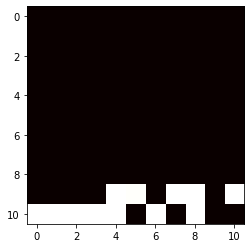

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,.,a,.,.,d,.



Turno: 179 Puntos:791
Almacen: [.] Actual: [b]


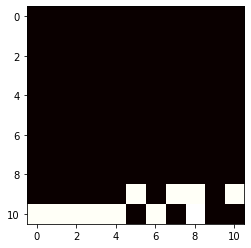

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,.,a,.,.,d,.



Turno: 180 Puntos:806
Almacen: [.] Actual: [a]


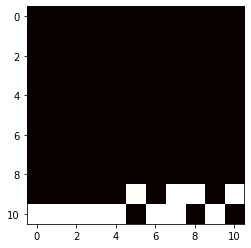

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,.,a,a,.,d,.



Turno: 181 Puntos:807
Almacen: [.] Actual: [a]


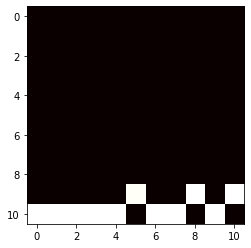

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,.,a,a,.,d,a



Turno: 182 Puntos:808
Almacen: [.] Actual: [b]


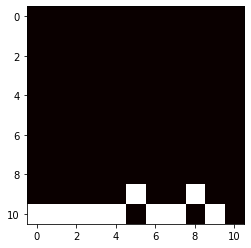

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,b,a,a,.,d,a



Turno: 183 Puntos:813
Almacen: [.] Actual: [a]


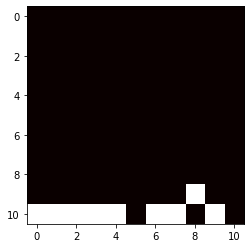

,0,1,2,3,4,5,6,7,8,9,10
A,2,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,.,c,a,c,b,a,b,3,a,2,b
J,.,b,c,b,a,b,a,a,.,d,a



Turno: 184 Puntos:816
Almacen: [.] Actual: [w]


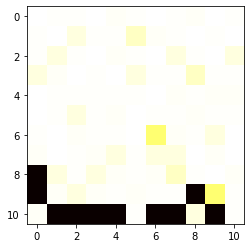

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,.,c,a,c,b,a,b,3,a,2,b
J,.,b,c,b,a,b,a,a,.,d,a



Turno: 185 Puntos:821
Almacen: [.] Actual: [a]


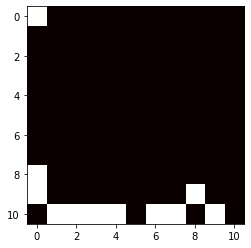

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,.,b,c,b,a,b,a,a,.,d,a



Turno: 186 Puntos:822
Almacen: [.] Actual: [a]


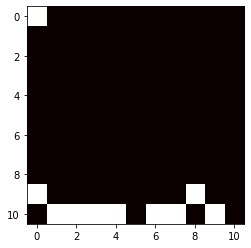

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,b,a,a,.,d,a



Turno: 187 Puntos:823
Almacen: [.] Actual: [a]


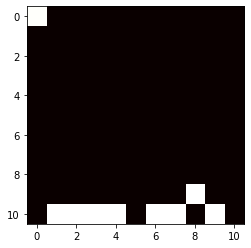

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,b,a,a,.,d,a



Turno: 188 Puntos:824
Almacen: [.] Actual: [a]


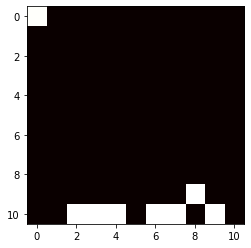

,0,1,2,3,4,5,6,7,8,9,10
A,.,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,b,a,a,.,d,a



Turno: 189 Puntos:825
Almacen: [.] Actual: [b]


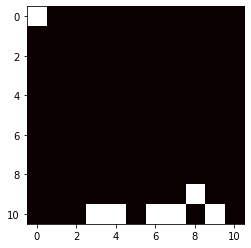

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,b,a,a,.,d,a



Turno: 190 Puntos:830
Almacen: [.] Actual: [a]


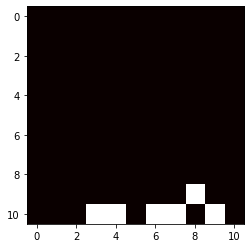

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,b,a,b,a,a,.,d,a



Turno: 191 Puntos:833
Almacen: [.] Actual: [a]


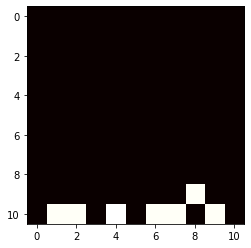

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,.,.,b,a,a,.,d,a



Turno: 192 Puntos:846
Almacen: [.] Actual: [1]


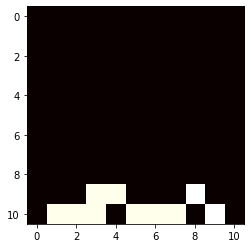

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,.,.,b,a,a,2,d,a



Turno: 193 Puntos:841
Almacen: [.] Actual: [a]


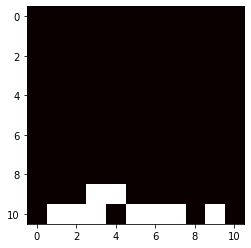

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,.,b,a,a,2,d,a



Turno: 194 Puntos:842
Almacen: [.] Actual: [a]


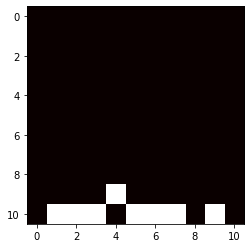

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,a,2,d,a



Turno: 195 Puntos:843
Almacen: [.] Actual: [a]


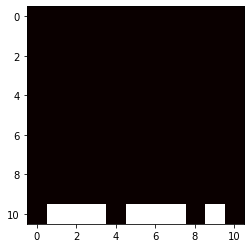

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,a,2,d,a



Turno: 196 Puntos:844
Almacen: [.] Actual: [a]


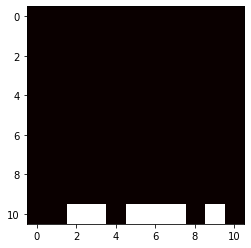

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,a,2,d,a



Turno: 197 Puntos:845
Almacen: [.] Actual: [1]


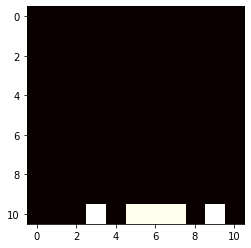

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,a,2,d,a



Turno: 198 Puntos:840
Almacen: [.] Actual: [a]


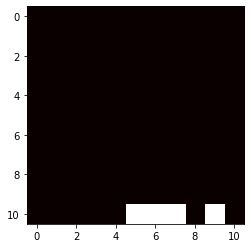

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,a,2,d,a



Turno: 199 Puntos:841
Almacen: [.] Actual: [1]


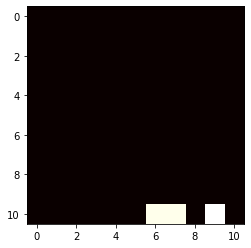

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,a,2,d,a



Turno: 200 Puntos:836
Almacen: [.] Actual: [a]


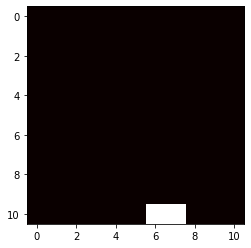

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,.,.,2,d,a



Turno: 201 Puntos:839
Almacen: [.] Actual: [a]


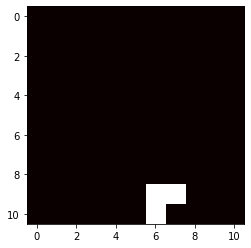

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,.,2,d,a



Turno: 202 Puntos:840
Almacen: [.] Actual: [a]


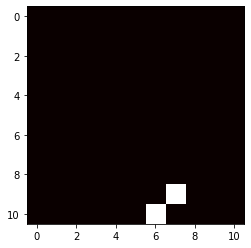

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,a,2,d,a



Turno: 203 Puntos:841
Almacen: [.] Actual: [b]


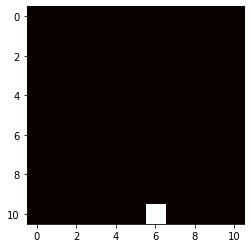

,0,1,2,3,4,5,6,7,8,9,10
A,b,a,a,2,b,a,2,a,b,2,a
B,a,2,c,a,a,3,b,a,2,a,2
C,a,c,a,2,b,a,2,c,a,2,c
D,c,b,2,a,2,c,a,a,3,a,a
E,2,a,a,a,a,a,2,b,a,b,b
F,2,a,c,a,b,2,a,a,b,a,a
G,a,2,b,a,a,2,d,b,a,c,2
H,b,2,a,b,c,a,c,c,2,b,2
I,a,c,a,c,b,a,b,3,a,2,b
J,a,b,c,a,a,b,a,a,2,d,a



Turno: 204 Puntos:846
Almacen: [.] Actual: [a]
Partida terminada, GG:👏


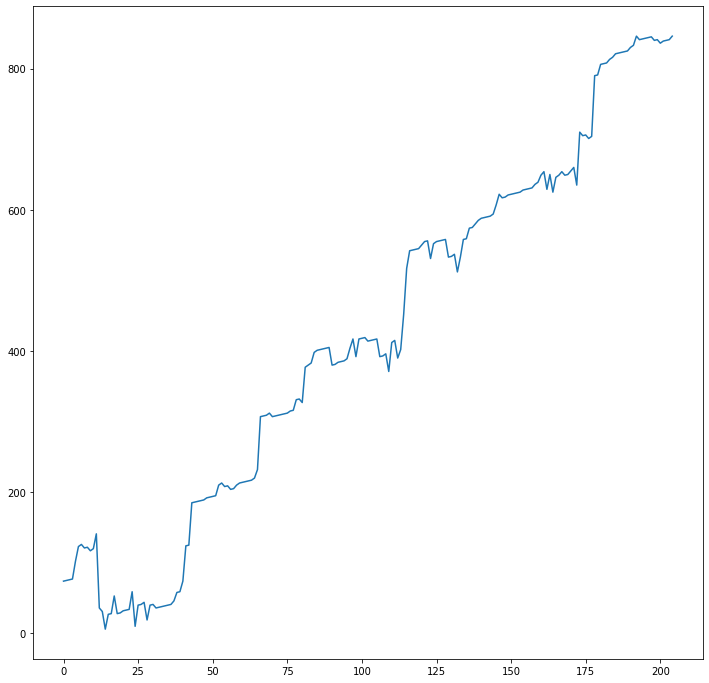

In [93]:
import random
import math
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[[i,j], 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]    
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 11) for i in range(11)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint")#self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: [int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])])(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    fig = plt.figure(figsize=(12, 12))
    plt.plot(list(range(len(self.score))), self.score)
    plt.show()

  def getHint(self):
    prevObjs = sum(1 for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, [0,0]]
    debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix([i,j])
          newScore = sum(sum(self.objects[b][1] - (b == "." or 0) for b in a) for a in newObj.matrix) + (prevObjs - newObj.minDistanceToElement((i,j), ["1", 2]))
          if newScore>tempValues[0]: tempValues = [newScore, [i,j]]
          debugValues[i][j] = newScore
    plt.imshow(debugValues, cmap='hot', interpolation='nearest')
    plt.show()
    return tempValues[1]
  
  def minDistanceToElement(self, coordinates, elements):
    visited = set()
    q = [(coordinates, 0)]
    while q:
        n, distance = q.pop(0)
        if n in visited:
            continue
        visited.add(n)
        for i, j in ((n[0]-1, n[1]), (n[0]+1, n[1]), (n[0], n[1]-1), (n[0], n[1]+1)):
            if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]):
                continue
            if self.matrix[i][j] in elements:
                return distance+1
            q.append(((i,j), distance+1))
    return 0   
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(([n[0][0]-1, n[0][1]], [n[0][0], n[0][1]+1], [n[0][0]+1, n[0][1]], [n[0][0], n[0][1]-1])):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    self.visitedMatrix = [[False]*len(self.matrix[0]) for i in range(len(self.matrix))]
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      self.visitedMatrix[n[0]][n[1]] = True
      for i in (lambda l:[j for j in l if j[0]>=0 and j[1]>=0])([[n[0]-1, n[1]], [n[0], n[1]+1], [n[0]+1, n[1]], [n[0], n[1]-1]]):
        try:
          if (not self.visitedMatrix[i[0]][i[1]]) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
        except:
          pass
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()

**Bot Encoding**

In [ ]:
import copy
copyObj = copy.deepcopy(g)

In [ ]:
copyObj.__dict__

{'objects': {'.': ['.', 0],
  'a': ['b', 1],
  'b': ['c', 5],
  'c': ['d', 25],
  'd': ['e', 125],
  'e': ['e', 625],
  '1': ['1', -25],
  '2': ['3', -5],
  '3': ['4', 50],
  '4': ['4', 500],
  'x': ['x', -50]},
 'matrix': [['.', 'b', '1', '2', 'b', '1'],
  ['.', '.', '.', 'a', '3', '.'],
  ['.', '.', 'a', '.', 'c', 'c'],
  ['a', '.', '.', 'a', '.', 'c'],
  ['a', '.', 'a', 'a', '1', '.'],
  ['.', 'a', 'a', 'c', '.', 'b']],
 'seq': '',
 'turn': 9,
 'score': [67, 42, 43, 18, 20, -5, -30, 116, 116, 116, 116, 116, 119, 94],
 'storage': '.',
 'bigFoots': [[[4, 4], 9, False],
  [[0, 2], 9, False],
  [[0, 3], 7, True],
  [[0, 5], 1, False]],
 'actual': 'a',
 'tr': <__main__.Trie at 0x7f2aa84123d0>,
 'visitedMatrix': [[False, False, False, False, False, True],
  [False, False, False, False, False, True],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False]]}

Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,a,2,b,.
B,.,1,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 7 Puntos:116
Almacen: [.] Actual: [a]
Mover a casilla: a1


,0,1,2,3,4,5
A,.,b,.,2,b,.
B,.,.,1,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,1,c
E,a,.,a,a,.,.
F,.,a,a,c,.,b



Turno: 8 Puntos:119
Almacen: [.] Actual: [1]
Mover a casilla: a5


,0,1,2,3,4,5
A,.,b,1,2,b,1
B,.,.,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 9 Puntos:94
Almacen: [.] Actual: [a]
Mover a casilla: exit
Partida terminada, GG:👏


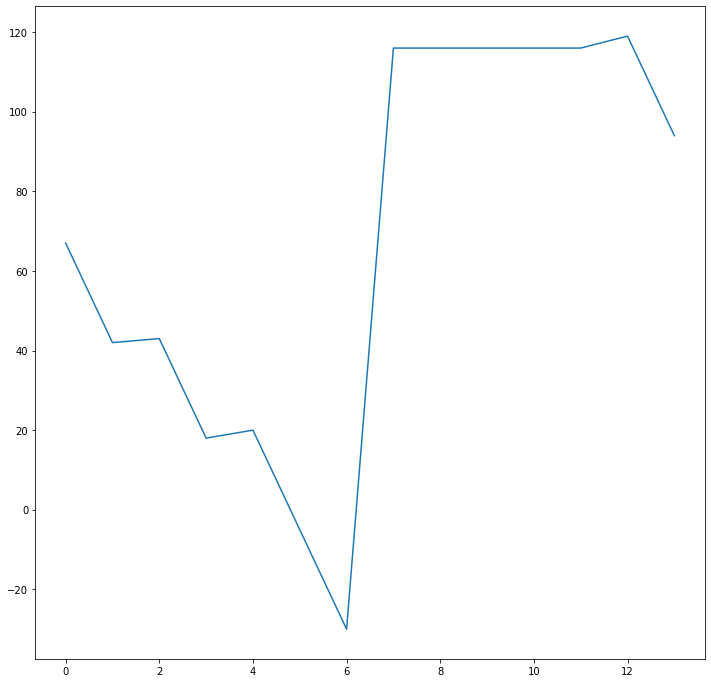

In [ ]:
copyObj.main()